# Redes Neuronales Recurrentes

Basado en el capítulo 6 del libro "Deep Learning with Python" de Francois Chollet, 2018 Manning

Las redes que hemos visto hasta ahora han sido feed-forward, sin ningún mecanismo para memorizar resultados anteriores: cada entrada es procesada de manera independiente de las demas entradas.
Si se quiere procesar una secuencia en redes densas, es necesario codificarla como una sola instancia que se procesa de manera atómica.




En Keras, las capas recurrentes pueden ejecutarse en 2 modos: 
- pueden retornar la totalidad de las secuencias de salidas sucesivas para cada paso de tiempo, a través de tensores 3D (batch_size, timesteps, output_features)
- pueden retornar la salida correspondiente a cada paso, sin retornar las salidas anteriores, a través de un tensor 2D (batch_size, output_features).

## SimpleRNN

Vamos a definir un modelo secuencial con dos componentes:
- Tenemos primero una capa **Embedding**, que define un espacio vectorial de 32 dimensiones para representar las críticas textuales de películas, considerando las 10000 palabras o términos más frecuentes.
- Tenemos luego una capa **SimpleRNN**, que recibe la representación de los Embeddings, que por defecto retorna la última salida. Si quisieramos una concatenación de las salidas, habríamos poder especificado el parámetro *return_sequences=True*.

La capa **SimpleRNN** consiste en la utilización de 2 matrices, una para las entradas y otra para las salidas anteriores, así como un sesgo que sirven para calcular la agregación recurrente que es luego pasada por una linearidad (tanh por defecto).

### Preparación de los datos de entrada: Embedding

Vamos a utilizar el dataset *imdb* de Keras, un compendio textual de críticas de cine.

In [5]:
import time

In [2]:
from keras.datasets import imdb
from keras.preprocessing import sequence

In [3]:
max_features = 10000 # Consideramos las 10000 palabras mas frecuentes
maxlen = 500         # El largo de cada review será de 500 palabras
embedding_dim = 32    # El embedding representará las palabras en un espacio de 32 dimensiones

Cargamos el dataset

In [4]:
print("Cargando los datos...")
(input_train, y_train), (input_test, y_test) = imdb.load_data(num_words=max_features)
print(len(input_train), "secuencias de entrenamiento")
print(len(input_test), "secuencias de evaluación")

Cargando los datos...
25000 secuencias de entrenamiento
25000 secuencias de evaluación


Cada review es una secuencia con el ID de la palabra:

In [6]:
input_train[0:3]

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

En la variable dependiente tenemos el tipo de sentimiento (1: Positivo, 0: Negativo) que queremos predecir

In [7]:
y_train[0:3]

array([1, 0, 0], dtype=int64)

Completamos las reviews que no logran alcanzar 500 palabras, truncamos las que los sobrepasan.

In [8]:
input_train = sequence.pad_sequences(input_train, maxlen=maxlen)
input_test = sequence.pad_sequences(input_test, maxlen=maxlen)
print(input_train.shape)
print(input_test.shape)

(25000, 500)
(25000, 500)


Tenemos en total 25000 reviews de entrenamiento y de evaluación, cada una con 500 palabras.

### Definimos el modelo recurrente y lo entrenamos

In [11]:
from keras.layers import Embedding, SimpleRNN, Dense
from keras.models import Sequential

In [13]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim)) #10000 xxxx con 32 XXXX
model.add(SimpleRNN(embedding_dim))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 322,113
Trainable params: 322,113
Non-trainable params: 0
_________________________________________________________________


Tenemos que la entrada es un paquete de "series de tiempo", donde tenemos que cada batch (primer eje) tiene un número de de pasos de tiempo (2o eje) cada uno usando una representación en 32 dimensiones.

Al haber utilizado una capa recurrente que no devuelve la secuencia de activaciones anteriores, solo consideramos la última activación como salida, por lo que la salida de la capa SimpleRNN es un tensor con el primer eje representando el batch_size y el segundo eje con el número de unidades (neuronas) de la capa, que son finalmente conectadas con la capa densa de salida.

Vamos a entrenar el modelo durante 10 épocas, con un mini batch de a 128 instancias a la vez.
Definimos además que el 20\% de los datos de entrenamiento se separan para validación y monitoreo.

In [14]:
t_start = time.time()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

t_end = time.time()
print("Tiempo de entrenamiento: %2.2f minutos" % ((t_end - t_start)/60) )

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 16s 820us/step - loss: 0.5976 - acc: 0.6683 - val_loss: 0.5184 - val_acc: 0.7610
Epoch 2/10
20000/20000 [==============================] - 15s 751us/step - loss: 0.3751 - acc: 0.8455 - val_loss: 0.5965 - val_acc: 0.7344
Epoch 3/10
20000/20000 [==============================] - 15s 750us/step - loss: 0.2764 - acc: 0.8910 - val_loss: 0.4062 - val_acc: 0.8258
Epoch 4/10
20000/20000 [==============================] - 15s 753us/step - loss: 0.2150 - acc: 0.9194 - val_loss: 0.3656 - val_acc: 0.8450
Epoch 5/10
20000/20000 [==============================] - 15s 733us/step - loss: 0.1434 - acc: 0.9498 - val_loss: 0.3727 - val_acc: 0.8558
Epoch 6/10
20000/20000 [==============================] - 15s 749us/step - loss: 0.0914 - acc: 0.9700 - val_loss: 0.5680 - val_acc: 0.7644
Epoch 7/10
20000/20000 [==============================] - 15s 750us/step - loss: 0.0601 - acc: 0.9822 - val_loss: 0.6

### Evaluación de los resultados

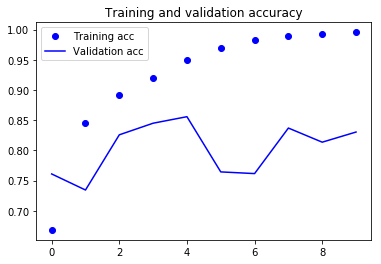

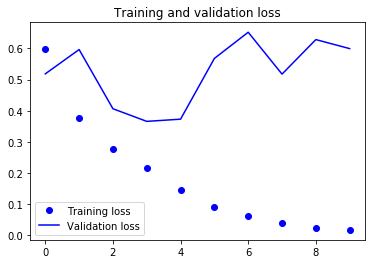

In [16]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Llegamos a aproximadamente 85% de accuracy en la predicción del sentimiento de los reviews.
Esta cifra no es muy alta y se puede explicar por solo considerar las primeras 500 palabras de cada review y por el hecho de que **SimpleRNN** es un modelo cuyos estados son rápidamente olvidados (problema del *vanishing gradient*).

Intentemos con un modelo un poco mas complejo, con 3 capas de SimpleRNN. Para poder conectar varias capas recurrentes, es necesario conservar las secuencias de los estados precedentes (no se puede utilizar el modo que produce y tiene en cuenta solamente el último valor):

In [18]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim)) #10000 xxxx con 32 XXXX
model.add(SimpleRNN(embedding_dim, return_sequences=True))
model.add(SimpleRNN(embedding_dim, return_sequences=True))
model.add(SimpleRNN(embedding_dim))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 326,273
Trainable params: 326,273
Non-trainable params: 0
_________________________________________________________________


Nótese cómo la última capa no retorna la secuencia de activaciones precedentes, pues estas no son necesarias para la comparación del valor predicho con el valor real.

Entrenamos el modelo con 10 épocas (cada una dura 40 segundos en una máquina normal)

In [14]:
t_start = time.time()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

t_end = time.time()
print("Tiempo de entrenamiento: %2.2f minutos" % ((t_end - t_start)/60) )

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 39s 2ms/step - loss: 0.6305 - acc: 0.6205 - val_loss: 0.5254 - val_acc: 0.7392
Epoch 2/10
20000/20000 [==============================] - 38s 2ms/step - loss: 0.4099 - acc: 0.8219 - val_loss: 0.4325 - val_acc: 0.8218
Epoch 3/10
20000/20000 [==============================] - 38s 2ms/step - loss: 0.3020 - acc: 0.8783 - val_loss: 1.3279 - val_acc: 0.6046
Epoch 4/10
20000/20000 [==============================] - 39s 2ms/step - loss: 0.2339 - acc: 0.9108 - val_loss: 0.4999 - val_acc: 0.7810
Epoch 5/10
20000/20000 [==============================] - 38s 2ms/step - loss: 0.1534 - acc: 0.9456 - val_loss: 0.5009 - val_acc: 0.7966
Epoch 6/10
20000/20000 [==============================] - 40s 2ms/step - loss: 0.0846 - acc: 0.9722 - val_loss: 0.5509 - val_acc: 0.8110
Epoch 7/10
20000/20000 [==============================] - 40s 2ms/step - loss: 0.0452 - acc: 0.9854 - val_loss: 0.6982 - val_acc:

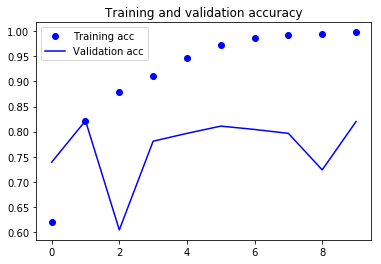

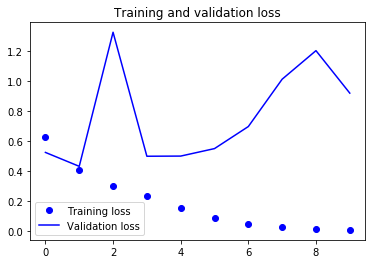

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Vemos que definitivamente con un **SimpleRNN**, así tengamos más de una 1 capa, logramos detectar algunos patrones secuenciales, pero estos no son lo suficientemente significativos para poder obtener resultados excelentes en el tratamiento de lenguaje natural.

### Modelo utilizando LSTMs

Keras tienen buenos valores por defecto, en vez de un SimpleRNN, usemos modulos LSTM para clasificar los reviews.

In [19]:
from keras.layers import LSTM

In [21]:
model = Sequential()
model.add(Embedding(max_features, embedding_dim)) #10000 xxxx con 32 XXXX
model.add(LSTM(embedding_dim))
model.add(Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [22]:
t_start = time.time()

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(input_train, y_train, epochs=10, batch_size=128, validation_split=0.2)

t_end = time.time()
print("Tiempo de entrenamiento: %2.2f minutos" % ((t_end - t_start)/60) )

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 41s 2ms/step - loss: 0.5374 - acc: 0.7367 - val_loss: 0.3667 - val_acc: 0.8502
Epoch 2/10
20000/20000 [==============================] - 40s 2ms/step - loss: 0.2978 - acc: 0.8827 - val_loss: 0.3212 - val_acc: 0.8646
Epoch 3/10
20000/20000 [==============================] - 41s 2ms/step - loss: 0.2401 - acc: 0.9086 - val_loss: 0.2984 - val_acc: 0.8830
Epoch 4/10
20000/20000 [==============================] - 44s 2ms/step - loss: 0.2045 - acc: 0.9250 - val_loss: 0.3022 - val_acc: 0.8772
Epoch 5/10
20000/20000 [==============================] - 40s 2ms/step - loss: 0.1828 - acc: 0.9338 - val_loss: 0.2977 - val_acc: 0.8874
Epoch 6/10
20000/20000 [==============================] - 39s 2ms/step - loss: 0.1655 - acc: 0.9405 - val_loss: 0.2948 - val_acc: 0.8876
Epoch 7/10
20000/20000 [==============================] - 40s 2ms/step - loss: 0.1498 - acc: 0.9465 - val_loss: 0.4856 - val_acc:

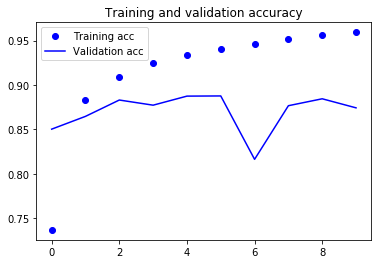

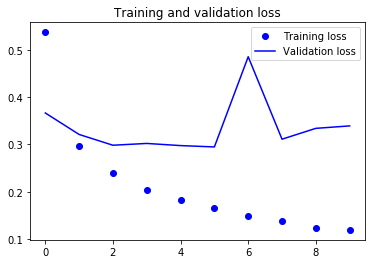

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Con un módulo LSTM, pudimos lograr obtener un accuracy del 89%.
Esto es mucho mejor que con el SimpleRNN, dado que los LSTMs sufren mucho menos del olvido causado por el desvanecimiento de gradiente.
Sin embargo podría ser mucho mejor:
- si se busca un mejor tuning de los hyper-parámetros, como las dimensiones de representación del embedding, o la dimensionalidad de salida del LSTM
- si se utilizara algún mecanismo de regularización como el dropout secuencial

De cualquier manera el análisis de sentimiento es una tarea bastante básica que no requiere de los mecanismos de memoria de los LSTMs.